In [7]:
import argparse
from pathlib import Path
import time
import cv2
from segment_anything import sam_model_registry, SamPredictor
import numpy as np
from matplotlib import pyplot as plt
import open3d as o3d
from utils.annotationdataset import AnnotationDataset
from utils.annotationimage import AnnotationImage, AnnotationObject
from utils.annotationscene import AnnotationScene
from utils.voxelgrid import VoxelGrid
import pandas as pd
import pickle
from scipy.spatial.distance import cdist
from copy import deepcopy   
from scipy.ndimage import generic_filter

In [8]:
sam_checkpoint = "model_checkpoints/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/david/miniconda3/envs/NTOMAT/lib/python3.11/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


In [9]:
scene = AnnotationScene(None, None, None, None, None)
scene.scene_from_pickle("debug_data_promptgeneration")

In [10]:
def project_voxelgrid(self, img_width, img_height, intrinsics, cam_pose=None, voxelgrid=None):
    projection_renderer = o3d.visualization.rendering.OffscreenRenderer(img_width, img_height)

    projection_renderer.scene.set_background([0.0, 0.0, 0.0, 1.0])
    projection_renderer.scene.view.set_post_processing(False)

    mtl = o3d.visualization.rendering.MaterialRecord()
    # mtl.base_color = [1.0, 1.0, 1.0, 1.0]  # RGBA, does not replace the mesh color
    mtl.shader = "defaultUnlit"

    projection_renderer.scene.clear_geometry()
    projection_renderer.scene.add_geometry("grid", voxelgrid, mtl)

    intrinsics = intrinsics#o3d.camera.PinholeCameraIntrinsic(img_width, img_height, intrinsics[0, 0], intrinsics[1, 1], intrinsics[0, 2], intrinsics[1, 2])
    #extrensics: translation 2 meters above self.poi in z. Looking down
    
    pose = cam_pose
    extrinsics = np.linalg.inv(pose.tf)

    projection_renderer.setup_camera(intrinsics, extrinsics)
    img = np.asarray(projection_renderer.render_to_image()).astype(np.uint8)

    cv2.imshow("img", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    return img

In [15]:
def identify_voxels_in_scene(self, scene):
    print("Starting voxel identification...")

    # Initialize camera intrinsics
    intrinsics_start = time.time()
    intrinsics = o3d.camera.PinholeCameraIntrinsic(
        scene.img_width,
        scene.img_height,
        scene.camera_intrinsics[0, 0],
        scene.camera_intrinsics[1, 1],
        scene.camera_intrinsics[0, 2],
        scene.camera_intrinsics[1, 2]
    )

    num_ids = max(scene.scene_object_ids)+2

    # Set of voxels
    voxel_correspondences_global = {tuple(voxel.grid_index): np.zeros(num_ids, dtype=int) for voxel in self.o3d_grid.get_voxels()}

    # Process each annotation image
    for img_idx, image in enumerate(scene.annotation_images.values()):
        if not image.annotation_accepted:
            continue


        # Get camera pose
        pose = image.camera_pose

        rgb_offscreen = project_voxelgrid(self, scene.img_width, scene.img_height, intrinsics, cam_pose=pose, voxelgrid=self.o3d_grid)

        # Convert and scale grid positions
        grid_position = np.array(rgb_offscreen).astype(np.float32)
        grid_position /= np.array([255, 255, 255])
        grid_position *= np.array([self.width/self.voxel_size, self.height/self.voxel_size, self.depth/self.voxel_size])
        grid_position = np.round(grid_position).astype(np.int32)
        import matplotlib.pyplot as plt
        segmap = image.get_complete_segmap()

        plt.figure()
        plt.imshow(segmap)
        plt.imshow(rgb_offscreen, alpha=0.5)
        plt.savefig(f"segmap_grid_position_{img_idx}.png")
        # Remove background pixels and update voxel correspondences
        valid_positions_mask = (grid_position != (0, 0, 0)).all(axis=-1)
        valid_grid_positions = grid_position[valid_positions_mask]
        valid_ids = image.get_complete_segmap()[valid_positions_mask]
        for pos, voxel_id in zip(valid_grid_positions, valid_ids):
            pos_tuple = tuple(pos)
            if pos_tuple in voxel_correspondences_global:
                voxel_correspondences_global[pos_tuple][voxel_id] += 1

    # Deepcopy the grid for coloring
    colored_voxel_grid = deepcopy(self.o3d_grid)

    # Remove all voxels from the new grid
    for voxel in colored_voxel_grid.get_voxels():
        colored_voxel_grid.remove_voxel(voxel.grid_index)

    # Filter and add colored voxels to the new grid
    for key, value in voxel_correspondences_global.items():
        if (value == 0).all():
            continue
        id = np.argmax(value)
        if id != 0:
            voxel = o3d.geometry.Voxel(key, [id / 255] * 3)
            colored_voxel_grid.add_voxel(voxel)

    # Filter out noise voxels
    for voxel in colored_voxel_grid.get_voxels():
        grid_index = tuple(voxel.grid_index)
        count = sum(
            np.argmax(voxel_correspondences_global.get((grid_index[0]+i, grid_index[1]+j, grid_index[2]+k), np.zeros(num_ids, dtype=int))) 
            == np.argmax(voxel_correspondences_global[grid_index])
            for i in range(-1, 2)
            for j in range(-1, 2)
            for k in range(-1, 2)
            if not (i == j == k == 0)
        )
        if count < 2:
            colored_voxel_grid.remove_voxel(grid_index)
    o3d.visualization.draw_geometries([colored_voxel_grid])
    self.o3d_grid_id = colored_voxel_grid

Starting voxel identification...
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x82679e50 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
0, 176
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x82679e50 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
0, 176
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x82679e50 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
0, 176
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x82679e50 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
0, 176
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x82679e50 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
0, 174
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x82679e50 (threading is enabled)
EGL(1.5)
OpenGL(4.1)
0, 176


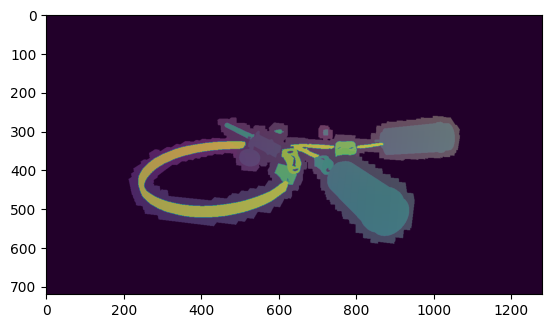

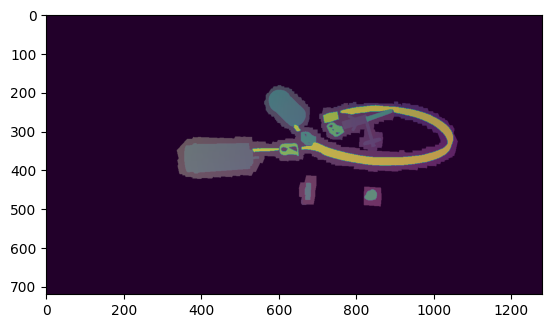

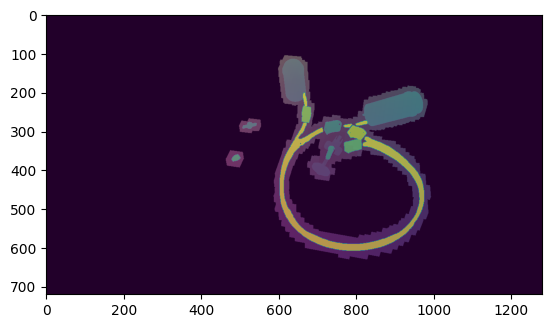

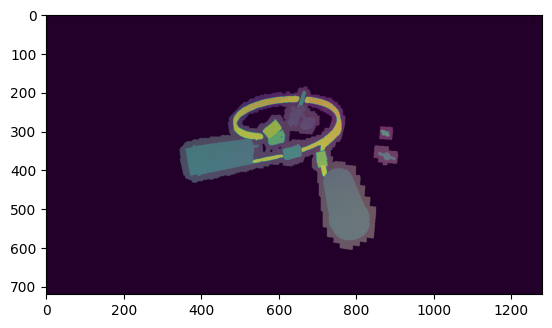

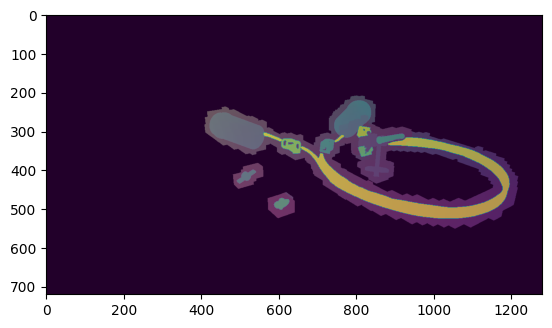

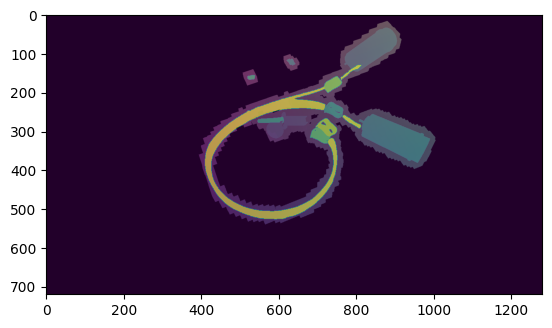

In [16]:
identify_voxels_in_scene(scene.voxel_grid, scene)

In [6]:
def get_prompt_points_from_mask(mask, debug_visualization=True, just_one_point=False):

    # skeleton = cv2.ximgproc.thinning(mask)

    # for every connected component erode it until it has 10% of its original size
    all_points = []
    skeleton = np.zeros_like(mask)

    if just_one_point:
        segment_points = np.argwhere(mask > 0)
        segment_points = segment_points.reshape(-1, 2)
        initial_size = len(segment_points)
        segment_mask = mask
        while len(segment_points) > 0.1 * initial_size:
            segment_mask = cv2.erode(segment_mask, np.ones((3, 3), np.uint8), iterations=1)
            segment_points = np.argwhere(segment_mask > 0)
            segment_points = segment_points.reshape(-1, 2)
        skeleton += segment_mask
        if len(segment_points) > 0:
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
            _, _, centers = cv2.kmeans(segment_points.astype(np.float32), 1, None, criteria, 10, cv2.KMEANS_PP_CENTERS)
            all_points.extend(centers)
    else:
        num_labels, labels = cv2.connectedComponents(mask)
        for label in range(1, num_labels):  # Start at 1 to skip the background label (0)
            segment_mask = (labels == label).astype(np.uint8)
            segment_points = np.argwhere(segment_mask > 0)
            segment_points = segment_points.reshape(-1, 2)
            initial_size = len(segment_points)
            if initial_size < 10:
                continue

            points = np.unique(labels, return_counts=True)[1]
            num_points_per_segment = np.maximum(np.ceil(points / 3000), 1).astype(np.int32)

            if len(segment_points) > 0:
                while len(segment_points) > 0.1 * initial_size:
                    segment_mask = cv2.erode(segment_mask, np.ones((3, 3), np.uint8), iterations=1)
                    segment_points = np.argwhere(segment_mask > 0)
                    segment_points = segment_points.reshape(-1, 2)
                skeleton += segment_mask
                if len(segment_points) > num_points_per_segment[label]:
                    # Perform k-means
                    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
                    _, _, centers = cv2.kmeans(segment_points.astype(np.float32), num_points_per_segment[label], None, criteria, 10, cv2.KMEANS_PP_CENTERS)

                    # Snap centers to nearest skeleton points (corrected)
                    distances = cdist(centers, segment_points)
                    closest_point_indices = np.argmin(distances, axis=1)
                    snapped_centers = segment_points[closest_point_indices]
                    all_points.extend(snapped_centers)
                elif len(segment_points) > 0:
                    # If too few points for k-means, still include one
                    center_index = np.random.choice(len(segment_points))
                    all_points.append(segment_points[center_index])
    centers = np.array(all_points, dtype=np.int32)
        
    if debug_visualization:
        plt.figure(figsize=(10,10))
        plt.imshow(mask)
        plt.imshow(skeleton, cmap='gray', alpha=0.5)
        plt.scatter(centers[:, 1], centers[:, 0], c='r', s=10)
        plt.axis('off')
        plt.show()
        #plt savefig
        # plt.savefig('skeleton_img.png')

    return centers

In [7]:
def generate_auto_prompts(image, scene, predictor):
    '''
    takes an annotation object and generates prompts for it
    '''

    #1. generate mask from voxelgrid
    # -> get new segmentation map from voxelgrid (use offscreen rednerer project to pose)
    voxelgrid = scene.voxel_grid
    voxelgrid_segmap = voxelgrid.project_voxelgrid(scene.img_width, scene.img_height, scene.camera_intrinsics, image.camera_pose, voxelgrid.o3d_grid_id)
    voxelgrid_segmap = voxelgrid_segmap[:,:,0]
    #TODO add annotation_objects to scene_ids-> assign scene ids

    #plt voxelgrid_segmap
    #set figure size big 
    plt.figure(figsize=(20, 20))
    plt.imshow(voxelgrid_segmap)
    plt.show()

    #2. for every object in annotation object

    print("generating prompts")

    for obj in image.annotation_objects.values():
        if obj.mask is not None:
            print("mask not none")
            continue
        mask = np.zeros_like(voxelgrid_segmap)
        mask[voxelgrid_segmap == obj.scene_object_id] = 255
        
        #3. generate prompts
        prompt_points = get_prompt_points_from_mask(mask, debug_visualization=True)

        # visualize prompt point on rgb image
        img = cv2.imread(image.rgb_path)
        for point in prompt_points:
            cv2.circle(img, (point[1], point[0]), 3, (0, 255, 0), -1)

        for point in prompt_points:
            image.active_object = obj
            image.add_prompt([[point[1], point[0]]], [1], predictor)

        for scene_object_id in scene.scene_object_ids:
            if scene_object_id != obj.scene_object_id:
                mask = np.zeros_like(voxelgrid_segmap)
                mask[voxelgrid_segmap == scene_object_id] = 255
                if np.sum(mask) == 0:
                    continue

                prompt_points = get_prompt_points_from_mask(mask, debug_visualization=True, just_one_point=True)
                for point in prompt_points:
                    image.active_object = obj
                    image.add_prompt([[point[1], point[0]]], [0], predictor)
    print("prompts generated")
    # -> get mask from segmentation map
    # -> generate positive prompts using get_prompt_points_from_mask
    # -> generate negative prompts using get_prompt_points_from_mask for all other objects

    # 3. for each prompt
    # -> add prompt to annotation object using add_prompt

    #TODO on write update obejcts.library
    img = image.generate_visualization()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.show()

In [8]:

for image in scene.annotation_images.values():
    if image.annotation_accepted:
        continue
    rgb = cv2.imread(image.rgb_path, cv2.IMREAD_COLOR)
    rgb = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
    predictor.set_image(rgb)
    generate_auto_prompts(image, scene, predictor)
    break

[ WARN:0@28.584] global loadsave.cpp:241 findDecoder imread_('/home/daviddylan/interdisciplinary/Dataset/scenes/p_001/rgb/000072.png'): can't open/read file: check file path/integrity


error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
